In [2]:
from explainer import Explainer
import datetime
import math
import pandas as pd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42  # Use TrueType (Type 42)

## Run the below code chunk to rerun all the experiments

In [ ]:
# INSERT HERE YOUR OPEN AI API KEY
os.environ['OPENAI_API_KEY'] = "YOUR_KEY"

##########################
# Initialisation
##########################

datetime_start = datetime.datetime(2025, 1, 1, 12, 0, 0)
datetime_hour = datetime_start + datetime.timedelta(hours=1)
datetime_day = datetime_start + datetime.timedelta(days=1)
datetime_week = datetime_start + datetime.timedelta(days=7)
datetime_month = datetime_week + datetime.timedelta(days=30)

filename = 'ablation_study_1.csv'

df = pd.DataFrame(columns=['ablation', 'repetition_llm', 'repetition_order', 'round', 'robot', 'retrieve_thresh', 'topic', 'question', 'answer', 'elapsed_time', 'length', 'correct_retrieved', 'incorrect_retrieved', 'total_to_retrieve', 'precision', 'recall', "false_positive_rate", "prompt_tokens_first", "response_tokens_first", "prompt_tokens_second", "response_tokens_second", 'prompt_tokens', 'response_tokens', 'length_reduction', 'wrong_ref'])

datetimes = [datetime_start, datetime_start, datetime_week, datetime_week, datetime_month, datetime_month]

explainer = Explainer()
explainer.del_user_knowledge()

ablations = ['one-stage', 'question', 'noRAG', 'question-noHeuristic', 'one-stage-noHeuristic', 'two-stage', 'two-stage-noRAG', 'two-stage-noHeuristic']

retrieve_thresholds = [0.35, 0.45, 0.55]

robots = ['nicol', 'tiago']

topics = {'nicol': ['asr_failure', 'missdetection', 'unreachable', 'grasping', 'unknown_object', 'unseen', 'unknown_action'], 'tiago': ['fall', 'vulnerable', 'door', 'emergency', 'overheat', 'lost', 'blocked']}

interactions = {
    'asr_failure': [
        {'log': 'There is a high uncertainty in the detected speech, and the actions point and pick might have been confused.',
        'question': 'Why did you point to the object when I said pick?'}, 
        {'log': 'There is a high uncertainty in the detected speech, and the actions point and put might have been confused.',
        'question': 'Why did you point to the object when I said put?'},
        {'log': 'There is a high uncertainty in the detected speech, and the actions pass and grasp might have been confused.',
        'question': 'Why did you pass to the object when I said grasp?'}],
    'missdetection': [
        {'log': 'The baseball detection uncertainty is high, the second most probable object type is orange.',
        'question': 'Why did you choose the baseball instead of the orange?'},
        {'log': 'The banana detection uncertainty is high, the second most probable object type is lemon.',
        'question': 'Why did you pick the banana instead of the lemon?'},
        {'log': 'The pear detection uncertainty is high, the second most probable object type is apple.',
        'question': 'Why did you point to the pear instead of the apple?'}],
    'unreachable': [
        {'log': 'The jello box is unreachable.',
        'question': "Why didn't you pick the jello box?"},
        {'log': 'The bowl is unreachable.',
        'question': "Why didn't you tidy up the bowl?"},
        {'log': 'The banana is unreachable.',
        'question': "Why didn't you throw away the banana?"}],
    'grasping': [
        {'log': 'The robot failed to grasp the bowl.',
        'question': "Why didn't you put the bowl in the box?"},
        {'log': 'The robot failed to grasp the cup.',
        'question': "Why couldn't you grasp the cup?"},
        {'log': 'The robot failed to grasp the baseball.',
        'question': 'Why did you fail to tidy up the baseball?'}],
    'unknown_object': [
        {'log': "The requested object peach is not known.",
        'question': "Why didn't you point to the peach?"},
        {'log': 'The requested object peeler is not known.',
        'question': "Why didn't you pick the peeler?"},
        {'log': 'The requested object tomato soup can is not known.',
        'question': "Why did you ignore the tomato soup can?"}],
    'unseen': [
        {'log': 'The requested object lemon is not seen.',
        'question': "Why didn't you give the lemon, when I had asked you to give me all the fruits?"},
        {'log': 'The requested object banana is not seen.',
        'question': "Why did you ignore the banana, when I had asked you to give me all the fruits?"},
        {'log': 'The requested object orange is not seen.',
        'question': "Why didn't you point to the orange, when I had asked you to point to all the fruits?"}],
    'unknown_action': [
        {'log': 'The requested action cut is not known.',
        'question': 'Why did you ignore my request to cut the apple?'},
        {'log': 'The requested action peel is not known.',
        'question': "Why didn't you peel the banana, when I had asked you to peel all the fruits?"},
        {'log': 'The requested action stack is not known.',
        'question': "Why can't you stack the cups?"}],
    'fall': [
        {'log': 'There is a detected fallen patient.',
        'question': 'What does the robot do after raising this alarm?'},
        {'log': 'There is a detected fallen patient.',
        'question': "Why didn't the robot stay in the room after detecting the fallen patient?"},
        {'log': 'There is a detected fallen patient.',
        'question': 'Why did the robot leave the room after detecting the fallen patient?'}],
    'vulnerable': [
        {'log': 'There is no person detected in a risky posture in room 101.',
        'question': "Why didn't the robot raise a vulnerable alarm in room 101?"},
        {'log': 'There is no person detected in a risky posture in room 102.',
        'question': "Did the robot detect any standing person in room 102?"},
        {'log': 'A person is detected in room 103, but the posture is not risky.',
        'question': 'Is there any standing person in room 103?'}],
    'door': [
        {'log': 'A closed door has been detected. Skipping room.',
        'question': 'How does the robot detect closed doors?'},
        {'log': 'A closed door has been detected. Skipping room.',
        'question': "Why didn't the robot enter the room?"},
        {'log': 'A closed door has been detected. Skipping room.',
        'question': "The door is half open. Why didn't the robot enter the room?"}],
    'emergency': [
        {'log': 'The robot emergency button has been pressed.',
        'question': 'How can I reset the robot?'},
        {'log': 'The robot emergency button has been pressed.',
        'question': "The robot is not moving, what should I do?"},
        {'log': 'The robot emergency button has been pressed.',
        'question': "How can the robot continue its task?"}],
    'overheat': [
        {'log': 'Head motor temperature is high. Waiting for it to cool down.',
        'question': "How much should I wait for the robot to cool down?"},
        {'log': 'Head motor temperature is high. Waiting for it to cool down.',
        'question': "Why is the robot not moving?"},
        {'log': 'Head motor temperature is high. Waiting for it to cool down.',
        'question': "When will the robot continue its task?"}],
    'lost': [
        {'log': 'The robot current position has too much uncertainty. The robot is lost.',
        'question': "Why is the robot not moving?"},
        {'log': 'The robot current position has too much uncertainty. The robot is lost.',
        'question': 'Why is the robot not patrolling?'},
        {'log': 'The robot current position has too much uncertainty. The robot is lost.',
        'question': "What issue is currently affecting the robot?"}],
    'blocked': [
        {'log': 'The robot is obstructed and cannot find any alternative path.',
        'question': "Why is the robot blocked?"},
        {'log': 'The robot is obstructed and cannot find any alternative path.',
        'question': "Why is the robot not moving?"},
        {'log': 'The robot is obstructed and cannot find any alternative path.',
        'question': "Why is the robot stuck?"}]
    }

initial_lengths = {0:{True:{}, False:{}},1:{True:{}, False:{}},2:{True:{}, False:{}}}

##########################
# Ablation study repetitions
##########################

for ablation in ablations:
    print("Ablation: " + ablation)
    
    use_RAG = 'noRAG' not in ablation
    use_heuristic = 'noHeuristic' not in ablation
    one_stage = 'one-stage' in ablation
    use_question = 'question' in ablation
    
    for robot in robots:
        print("Robot: " + robot)
        
        for repetition_llm in range(5):
            repetition_llm = repetition_llm + 5
            print("Repetition LLM: " + str(repetition_llm))
            
            for repetition_order in range(1):
                print("Repetition Order: " + str(repetition_order))
                
                for retrieve_thresh in retrieve_thresholds:
                    print("Retrieve Threshold: " + str(retrieve_thresh))
                    
                    if not use_RAG and retrieve_thresh != retrieve_thresholds[0]:
                        continue
                    
                    for topic in topics[robot]:
                        print("Topic: " + topic)
                        
                        explainer = Explainer(use_RAG=use_RAG, use_heuristic=use_heuristic, one_stage=one_stage, use_question = use_question, robot = robot, retrieve_thresh = retrieve_thresh)
                        user = 'user_' + ablation + '_' + robot + '_' + str(repetition_llm) + '_' + str(repetition_order) + '_' + str(retrieve_thresh) + '_' + topic
                        
                        print("user: " + user)
                        
                        available_topics = topics[robot].copy()
                        available_topics.remove(topic)
                        
                        for round in range(6):
                            print("Round: " + str(round))
                            
                            explainer.clear_logs()
                            explainer.reset_history()
                            concept_extraction_enabled = False
                            idx = math.floor(3 * random.random())
                            prompt_tokens_first = 0
                            response_tokens_first = 0
                            prompt_tokens_second = 0
                            response_tokens_second = 0
                            prompt_tokens = 0
                            response_tokens = 0
                            
                            if round == 1 or round ==2:
                                tmp_topic = available_topics[math.floor(len(available_topics) * random.random())]
                                available_topics.remove(tmp_topic)
                                if round == 2:
                                    topic_round_2 = tmp_topic
                                    
                            elif round == 4:
                                tmp_topic = topic_round_2
                                
                            else:
                                tmp_topic = topic
                            
                            log = interactions[tmp_topic][idx]['log']
                            question = interactions[tmp_topic][idx]['question']
                                
                            if round == 0 or round == 1:
                                concept_extraction_enabled = True
                                
                            if log != '' and question != '':
                                
                                # Generate explanation
                                explainer.add_log(datetimes[round], tmp_topic, log)
                                elapsed_time, answer, relevant_concepts, extracted_concepts, merged_concepts, usage = explainer.explain(datetimes[round], question, user, concept_extraction_enabled)
                                
                                relevant_concepts = [x["concept"] for x in relevant_concepts]
                                
                                for i in range(len(usage)):
                                    u = usage[i]
                                    if i == 0:
                                        prompt_tokens_first += u.prompt_tokens
                                        response_tokens_first += u.completion_tokens
                                    elif i == 1:
                                        prompt_tokens_second += u.prompt_tokens
                                        response_tokens_second += u.completion_tokens
                                        
                                prompt_tokens = prompt_tokens_first + prompt_tokens_second
                                response_tokens = response_tokens_first + response_tokens_second
                                
                            else:
                                elapsed_time = 0
                                answer = ''
                                
                                
                            length = len(answer)
                            length_reduction = 0
                            
                            # Compute baseline length if not available
                            if tmp_topic not in initial_lengths[idx][one_stage]:
                                if len(relevant_concepts) == 0 and length > 0:
                                    initial_lengths[idx][one_stage][tmp_topic] = length
                                else:
                                    explainer.clear_logs()
                                    explainer.reset_history()
                                    print("Initial round for length comparison.")
                                    user_initial = 'user_' + ablation + '_' + robot + '_' + str(repetition_llm) + '_' + str(repetition_order) + '_' + str(retrieve_thresh) + '_' + tmp_topic + '_initial'
                                    explainer.add_log(datetimes[0], tmp_topic, log)
                                    _, answer_initial, _, _ , _, _ = explainer.explain(datetimes[0], question, user_initial, False)
                                    initial_lengths[idx][one_stage][tmp_topic] = len(answer_initial)

                            if round == 1 or round == 2 or round == 3 or round == 4 or round == 5:
                                if initial_lengths[idx][one_stage][tmp_topic] > 0:
                                    length_reduction = (initial_lengths[idx][one_stage][tmp_topic] - length) / initial_lengths[idx][one_stage][tmp_topic]
                                
                            # Compute metrics
                            
                            correct_retrieved = None
                            incorrect_retrieved = None
                            total_to_retrieve = None
                            precision = None
                            recall = None
                            false_positive_rate = None
                            
                            if round == 0:
                                extracted_true = extracted_concepts
                                extracted_second_len = 0
                            
                            if round == 1 or round == 2 or round == 4:
                                incorrect_retrieved = len(relevant_concepts)
                                correct_retrieved = 0
                                total_to_retrieve = 0
                                precision = 0
                                recall = 0
                                false_positive_rate = incorrect_retrieved / (len(extracted_true) + extracted_second_len)
                                
                            if round == 1:
                                extracted_second_len = len(extracted_concepts) - merged_concepts
                            
                            elif round == 3 or round == 5:
                                correct_retrieved = 0
                                for concept in relevant_concepts:
                                    if concept in extracted_true:
                                        correct_retrieved += 1
                                incorrect_retrieved = len(relevant_concepts) - correct_retrieved
                                total_to_retrieve = len(extracted_true)
                                if len(relevant_concepts) != 0:
                                    precision = correct_retrieved / len(relevant_concepts)
                                if total_to_retrieve != 0:
                                    recall = correct_retrieved / total_to_retrieve
                                false_positive_rate = incorrect_retrieved / (len(extracted_true) + extracted_second_len)
                                
                            df.loc[len(df)] = [ablation, repetition_llm, repetition_order, round, robot, retrieve_thresh, tmp_topic, question, answer, elapsed_time, length, correct_retrieved, incorrect_retrieved, total_to_retrieve, precision, recall, false_positive_rate, prompt_tokens_first, response_tokens_first, prompt_tokens_second, response_tokens_second, prompt_tokens, response_tokens, length_reduction, 0]
                            df.to_csv(filename, index=False)

## Run the code below to import the raw results and perform the analysis and plotting

In [3]:
df = pd.read_csv('ablation_study.csv')

##########################
# Data preparation
##########################

df["length_reduction"] = df["length_reduction"].astype(float)
df["length_reduction"] = df["length_reduction"] * 100
df["stages"] = df["ablation"].apply(lambda x: "quest./r. context\nquery" if "one-stage" in x else "explanation\nquery")
df["total_retrieved"] = df["correct_retrieved"] + df["incorrect_retrieved"]
df["retrieval"] = df["total_retrieved"].apply(lambda x: True if not math.isnan(x) and x > 0 else False)
df["stages_retrieval"] = df["stages"] + ",\n" + df["retrieval"].apply(lambda x: "concepts retrieved" if x else "no concepts retrieved")

df_no_initial = df[df['round'] > 1]

df_by_stage = df_no_initial.groupby(['stages_retrieval']).agg({'elapsed_time': 'mean', 'length': 'mean', 'length_reduction': 'mean', 'correct_retrieved': 'mean', 'incorrect_retrieved': 'mean', 'prompt_tokens': 'mean', 'prompt_tokens_first': 'mean', 'prompt_tokens_second': 'mean', 'response_tokens_first': 'mean', 'response_tokens_second': 'mean', 'response_tokens': 'mean', 'precision': 'mean', 'recall': 'mean', "false_positive_rate": 'mean'}).reset_index()

df_summary_by_thresh_no_initial = df_no_initial.groupby(['ablation','retrieve_thresh', 'round']).agg({'elapsed_time': 'mean', 'length': 'mean', 'length_reduction': 'mean', 'correct_retrieved': 'mean', 'incorrect_retrieved': 'mean', 'prompt_tokens': 'mean', 'prompt_tokens_first': 'mean', 'prompt_tokens_second': 'mean', 'response_tokens_first': 'mean', 'response_tokens_second': 'mean', 'response_tokens': 'mean', 'precision': 'mean', 'recall': 'mean', "false_positive_rate": 'mean'}).reset_index()

df_summary_by_thresh_no_initial['ablation_thresh'] = df_summary_by_thresh_no_initial['ablation'] + '_' + df_summary_by_thresh_no_initial['retrieve_thresh'].astype(str)

ablation_thresh_values = ['one-stage-noRAG_0.35', 'one-stage-question_0.35', 'one-stage-question_0.45', 'one-stage-question_0.55', 'one-stage_0.35', 'one-stage_0.45', 'one-stage_0.55', 'two-stage-noRAG_0.35',  'two-stage_0.35', 'two-stage_0.45', 'two-stage_0.55']

df_summary_by_thresh_no_initial['ablation_thresh'] = pd.Categorical(df_summary_by_thresh_no_initial['ablation_thresh'], categories=ablation_thresh_values, ordered=True)


df_summary_by_thresh_no_initial['ablation_thresh'] = df_summary_by_thresh_no_initial['ablation_thresh'].cat.rename_categories({'one-stage-noRAG_0.35': 'quest./r. context\nquery,\nzero thresh\n', 'one-stage-question_0.35': 'question\nquery,\nlow thresh', 'one-stage-question_0.45': 'question\nquery,\nmid thresh', 'one-stage-question_0.55': 'question\nquery,\nhigh thresh', 'one-stage_0.35': 'r. context\nquery,\nlow thresh', 'one-stage_0.45': 'r. context\nquery,\nmid thresh', 'one-stage_0.55': 'r. context\nquery,\nhigh thresh', 'two-stage-noRAG_0.35': 'explanation\nquery,\nzero thresh', 'two-stage_0.35': 'explanation\nquery,\nlow thresh', 'two-stage_0.45': 'explanation\nquery,\nmid thresh', 'two-stage_0.55': 'explanation\nquery,\nhigh thresh'})

df_summary_by_thresh_no_initial['round'] = pd.Categorical(df_summary_by_thresh_no_initial['round'], categories=[2,3,4,5], ordered=True)
df_summary_by_thresh_no_initial['round'] = df_summary_by_thresh_no_initial['round'].cat.reorder_categories([3,5,2,4])
df_summary_by_thresh_no_initial['round'] = df_summary_by_thresh_no_initial['round'].cat.rename_categories({2: '1 week unknown', 3: '1 week known', 4: '1 month unknown', 5: '1 month known'})


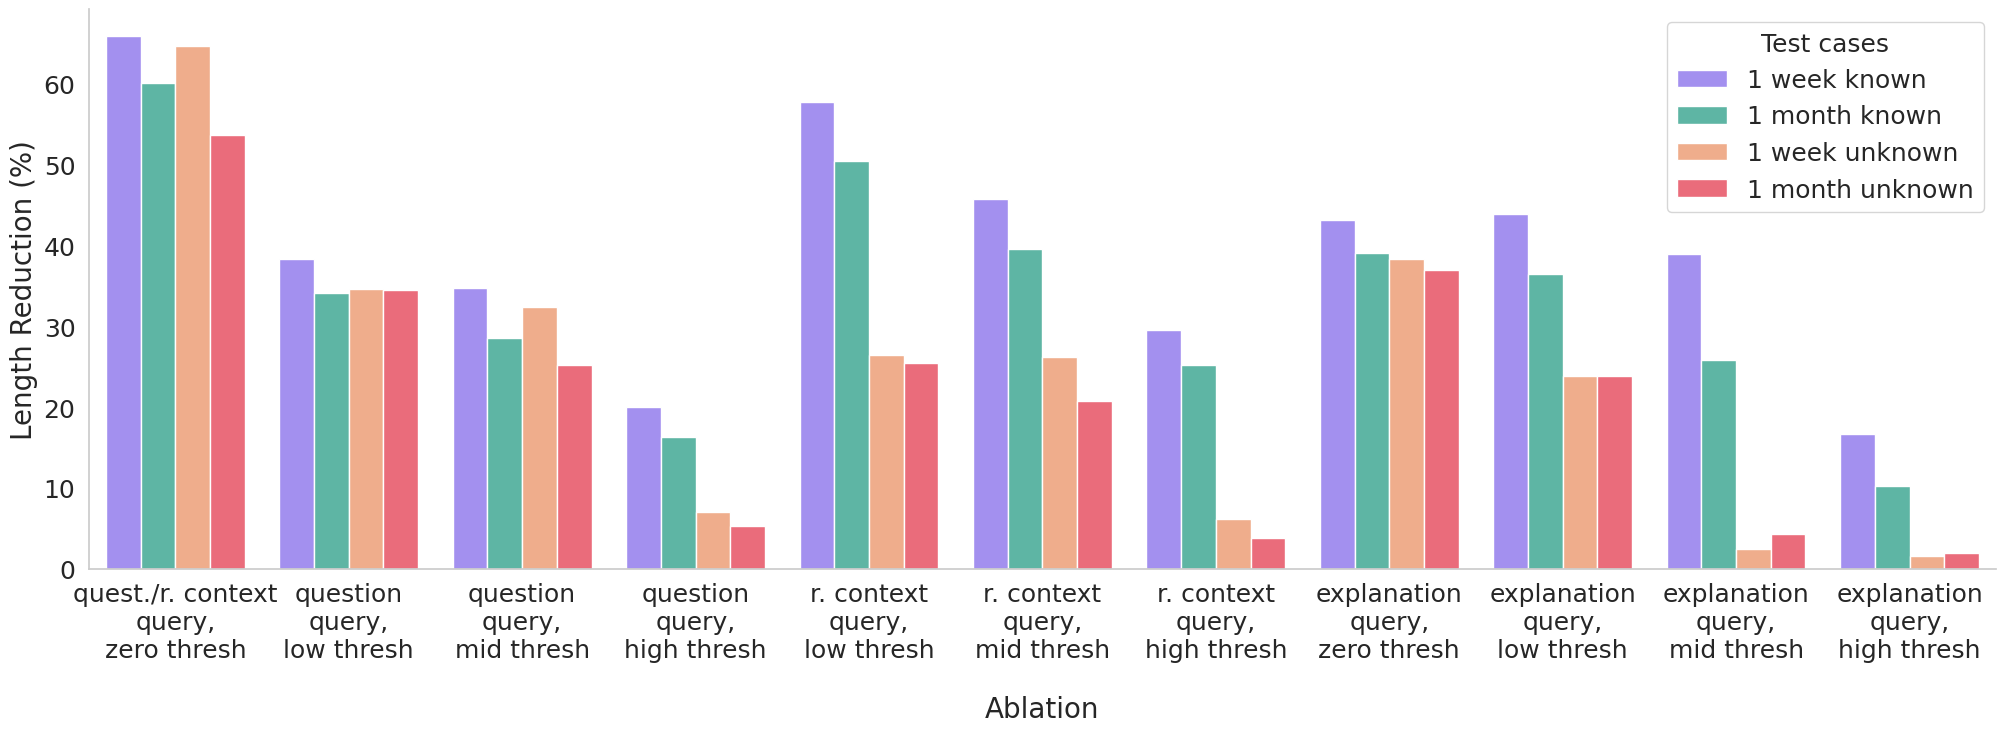

In [4]:
##########################
# Length reduction plot
##########################

palette = ["#9980FF", "#4fc4ad","#FFA77C", "#FF576B"]

sns.set(rc={'figure.figsize':(20,7)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="ablation_thresh", y="length_reduction", hue= "round", data=df_summary_by_thresh_no_initial, palette=palette)

sns.despine()
plt.tight_layout()

ax.yaxis.grid(False)
ax.set_xlabel('Ablation')
ax.set_ylabel('Length Reduction (%)')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(fontsize = 18)
ax.set_ylabel(ax.get_ylabel(), fontsize = 20)
ax.set_xlabel(ax.get_xlabel(), fontsize = 20)
ax.get_legend().set_title('Test cases', prop={'size':18})

# Increase margin of x label
# plt.gcf().subplots_adjust(bottom=0.55)

plt.savefig('length_reduction.pdf', bbox_inches='tight')
plt.show()


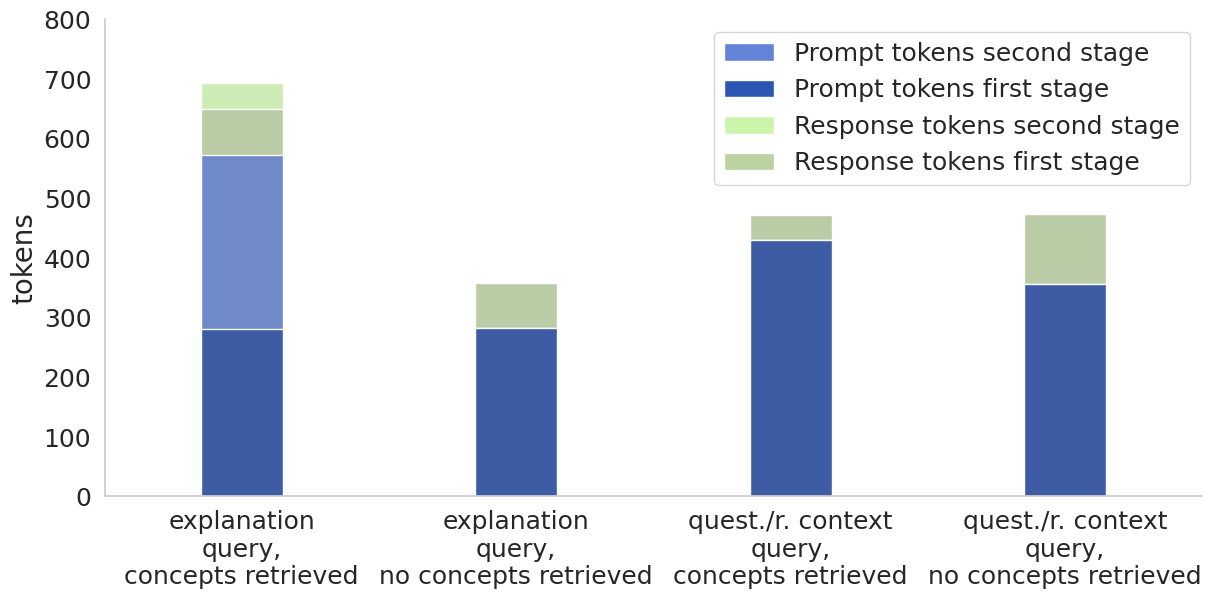

In [5]:
##########################
# Token length plot
##########################

df_by_stage['response_tokens_added'] = df_by_stage['prompt_tokens'] + df_by_stage['response_tokens']
df_by_stage['response_tokens_1'] = df_by_stage['prompt_tokens'] + df_by_stage['response_tokens_first']

sns.set(rc={'figure.figsize':(12,6)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="stages_retrieval", y="response_tokens_added", data=df_by_stage, color='#CCF5AC', errorbar=None, width=0.3)
ax = sns.barplot(x="stages_retrieval", y="response_tokens_1", data=df_by_stage, color='#BAD29F', errorbar=None, width=0.3)
ax = sns.barplot(x="stages_retrieval", y="prompt_tokens", data=df_by_stage, color='#6184D8', errorbar=None, width=0.3)
ax = sns.barplot(x="stages_retrieval", y="prompt_tokens_first", data=df_by_stage, color='#2D55B4', errorbar=None, width=0.3)


legend_handles = [
    Patch(facecolor='#6184D8', label='Prompt tokens second stage'),
	Patch(facecolor='#2D55B4', label='Prompt tokens first stage'),
	Patch(facecolor='#CCF5AC', label='Response tokens second stage'),
	Patch(facecolor='#BAD29F', label='Response tokens first stage'),
]

sns.despine()
plt.tight_layout()

ax.yaxis.grid(False)
ax.set_xlabel('')
ax.set_ylabel('tokens')
ax.set_ylim(ymax=800)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(handles=legend_handles, loc='upper right', ncols = 1, fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize = 20)

plt.savefig('prompt_response_tokens.pdf', bbox_inches='tight')
plt.show()